In [26]:
import random
import warnings

import numpy as np
from himalaya.backend import set_backend

from compare_variance_residual.simulation import generate_dataset

In [27]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)

In [28]:
feature_space_dimensions = [
    100,  # shared
    100,  # unique 0
    100,  # unique 1
]
scalars = [3 / 5, 1 / 5, 1 / 5]
# scalars = [1 / 3, 1 / 3, 1 / 3]
n_targets = 1000
n_samples_train = 10000
n_samples_test = 1000
n_samples = n_samples_train + n_samples_test
noise_scalar = 0.1

cv = 20
alphas = np.logspace(-4, 4, 10)

In [29]:
Xs, Y = generate_dataset(feature_space_dimensions, scalars, n_targets, n_samples, noise_scalar)

KeyboardInterrupt: 

# Variance Partitioning

In [5]:
from compare_variance_residual.variance_partitioning import variance_partitioning

In [6]:
(score_0, score_1, joint_score, vp_shared, vp_x1_unique, vp_x2_unique) = variance_partitioning(
    Xs, Y, n_samples_train, cv=cv, alphas=alphas
)

# Residual Method

In [7]:
from compare_variance_residual.residual import residual_method

In [8]:
_, _, residual_shared_score_1, residual_shared_score_2, residual_x1_unique, residual_x2_unique = residual_method(
    Xs, Y, n_samples_train, cv=cv
)

# Plotting

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
plt.style.use("nord")
sns.set_theme()

create columnar data frame containing predicted - actual score for variance partitioning and residual method across all voxels

In [11]:
vp_x1_unique_error = vp_x1_unique - scalars[1]
vp_x2_unique_error = vp_x2_unique - scalars[2]
residual_x1_unique_error = residual_x1_unique - scalars[1]
residual_x2_unique_error = residual_x2_unique - scalars[2]

# Columns: voxel index, error, method, feature space
voxel_index = np.arange(len(vp_x1_unique_error))
error = pd.DataFrame({
    "Voxel Index": np.concatenate(
        [voxel_index, voxel_index, voxel_index, voxel_index]),
    "Error": np.concatenate(
        [vp_x1_unique_error, vp_x2_unique_error, residual_x1_unique_error, residual_x2_unique_error]),
    "Method": ["Variance Partitioning"] * len(vp_x1_unique_error) * 2 + ["Residual"] * len(
        residual_x1_unique_error) * 2,
    "Feature Space": [r"$X_1$"] * len(vp_x1_unique_error) + [r"$X_2$"] * len(vp_x2_unique_error) +
                     [r"$X_1$"] * len(residual_x1_unique_error) + [r"$X_2$"] * len(residual_x2_unique_error),
})

error.head()

,Voxel Index,Error,Method,Feature Space
0,0,0.012879,Variance Partitioning,$X_1$
1,1,0.015811,Variance Partitioning,$X_1$
2,2,0.003376,Variance Partitioning,$X_1$
3,3,-0.016019,Variance Partitioning,$X_1$
4,4,0.009153,Variance Partitioning,$X_1$


create 2d histplot comparing

In [12]:
# Separate errors for Variance Partitioning and Residual Method by voxel
vp_error = error.query("Method == 'Variance Partitioning'").rename(columns={"Error": "VP Error"})
residual_error = error.query("Method == 'Residual'").rename(columns={"Error": "Residual Error"})

# Merge errors by Voxel Index
merged_error = pd.merge(vp_error[["Voxel Index", "VP Error", "Feature Space"]],
                        residual_error[["Voxel Index", "Residual Error", "Feature Space"]],
                        on=["Voxel Index", "Feature Space"])


<Figure size 1000x1000 with 0 Axes>

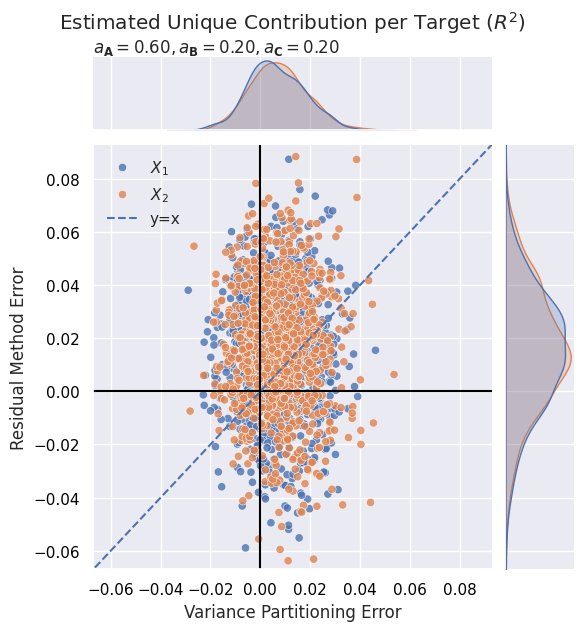

In [47]:
fig = plt.figure(figsize=(10, 10))


range_min = min(vp_error["VP Error"].min(), residual_error["Residual Error"].min())
range_max = max(vp_error["VP Error"].max(), residual_error["Residual Error"].max())
# add 5% padding
range_min -= 0.05 * abs(range_min)
range_max += 0.05 * abs(range_max)

sns.jointplot(
    data=merged_error,
    x="VP Error",  # Variance Partitioning Error
    y="Residual Error",  # Residual Method Error
    hue="Feature Space",
    alpha=0.8,
    kind="scatter",
    xlim=(range_min, range_max),
    ylim=(range_min, range_max)
)

# make x and y tick labels black
plt.tick_params(axis="both", which="major", labelcolor="black")

# draw 0 lines
plt.axhline(0, color="black", linestyle="-")
plt.axvline(0, color="black", linestyle="-")

# plot x=y line
plt.plot([-1, 1], [-1, 1], linestyle="--", label="y=x")

plt.legend()
plt.suptitle(r"Estimated Unique Contribution per Target ($R^2$)", y=1.05)
plt.title(rf"$a_\mathbf{{A}}={scalars[0]:.2f}, a_\mathbf{{B}}={scalars[1]:.2f}, a_\mathbf{{C}}={scalars[2]:.2f}$", y=1.2)
plt.xlabel("Variance Partitioning Error")
plt.ylabel("Residual Method Error")
plt.show()

bar plot of variances explained with each scalar

In [1]:
sns.catplot(scalars)

NameError: name 'sns' is not defined